In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install pystac-client rasterio geopandas  pyproj matplotlib numpy pandas
  !pip install rioxarray
  !pip install --upgrade stackstac
  !pip install planetary-computer

In [ ]:
from pystac_client import Client
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import io
import pandas as pd
import stackstac
import rasterio
from typing import Callable, Dict, List, Optional, Union
import planetary_computer as pc

In [ ]:
stac_url_panetary_computer = 'https://planetarycomputer.microsoft.com/api/stac/v1'

## Creating an xarray
* first We create a function to return stack items

In [ ]:
# itemediate function to handle data format
def handle_feature_collection(feature_collection):
  type_location_geojson = feature_collection["type"]
  if type_location_geojson not in ["Point", "Polygon", "feature", "FeatureCollection"]:

              raise ValueError("Only Point and Polygon types are supported.")

  if type_location_geojson == "FeatureCollection":
          return feature_collection["features"][0]["geometry"]

In [ ]:
def get_stack_items(stac_url:str,
                    collection:str,
                    datetime:str,
                    feature_collection: str,
                    cloud_cover:int = 10,
                    planet_comp:bool = True
                    ):

  client = Client.open(stac_url)
  feature_collection = handle_feature_collection(feature_collection)
  search = client.search(
    collections=[collection],
    intersects=feature_collection,
    datetime=datetime,
    query=[f"eo:cloud_cover<{cloud_cover}"],
    limit=10
    )
  if planet_comp:
    items = pc.sign(search)
  else:
    items = search.item_collection()

  print(f"Found {len(items)} items")

  return items



In [ ]:
# Define a GeoJSON feature collection for the search
feature_collection = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              35.091792388971584,
              0.5900286891046989
            ],
            [
              35.091792388971584,
              0.5741557135470998
            ],
            [
              35.123369292604906,
              0.5741557135470998
            ],
            [
              35.123369292604906,
              0.5900286891046989
            ],
            [
              35.091792388971584,
              0.5900286891046989
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

gdf = gpd.GeoDataFrame.from_features(feature_collection["features"])
bbox = gdf.total_bounds

In [ ]:
sentinel2_items = get_stack_items(stac_url_panetary_computer,'sentinel-2-l2a',
                                  "2021-01-01/2021-06-30", feature_collection,
                                  )

Found 14 items


In [ ]:
len(sentinel2_items)

14

create an xarray with stackstac

In [ ]:
bbox = tuple(bbox)

In [ ]:
# Create an xarray.DataArray from the items, reproject and stack by time.
resolution_degrees = 0.0000899
s2_stack = stackstac.stack(sentinel2_items, epsg=4326 ,bounds_latlon=bbox, resolution=resolution_degrees)
s2_stack

<xarray.DataArray 'stackstac-027fa18607be0de029dfcfff0727f708' (time: 14,
                                                                band: 17,
                                                                y: 178, x: 352)> Size: 119MB
dask.array<fetch_raster_window, shape=(14, 17, 178, 352), dtype=float64, chunksize=(1, 1, 178, 352), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * band                                     (band) <U7 476B 'AOT' ... 'preview'
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    ...                                       ...
    gsd                                      (band) object 136B 10.0 ... None
    proj:shape                               (band) object 136B [10980, 10980...
    common_name                              (band) object 136B None ... None
    center_wavelength                        (band) object 136B None ... None
    full_width_half_max                      (band) object 136B None ... None
    epsg                                     int64 8B 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(35.0917458, 0.5741014, 35.1233...
    crs:         epsg:4326
    transform:   | 0.00, 0.00, 35.09|\n| 0.00,-0.00, 0.59|\n| 0.00, 0.00, 1.00|
    resolution:  8.99e-05

In [ ]:
# Band names are not trivial from the initial query
s2_stack.band

<xarray.DataArray 'band' (band: 17)> Size: 476B
array(['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
       'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual', 'preview'], dtype='<U7')
Coordinates: (12/20)
  * band                                     (band) <U7 476B 'AOT' ... 'preview'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    s2:mgrs_tile                             <U5 20B '36NYF'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:degraded_msi_data_percentage          float64 8B 0.0
    instruments                              <U3 12B 'msi'
    ...                                       ...
    gsd                                      (band) object 136B 10.0 ... None
    proj:shape                               (band) object 136B [10980, 10980...
    common_name                              (band) object 136B None ... None
    center_wavelength                        (band) object 136B None ... None
    full_width_half_max                      (band) object 136B None ... None
    epsg                                     int64 8B 4326

# Pre-processing:
Steps taken to clean satellite data

Cloud masking: removing cloudy pixels for optical images

Sentinel 2 we use the scl band official documentation on the classifications can be found on ESA

In [ ]:
# Create mask values
mask_values = [ 3,8,9, 10]  # Cloud shadows , Cloud medium probability, Thin cirrus


In [ ]:
def value_mask(data_mask: xr.DataArray, mask_values: Union[int, List[int]]) -> xr.DataArray:
    """
    Mask data array using the provided mask values.
    :param data_mask xr.DataArray: Data array containing values to mask e.g., Sentinel-2 SCL band.
    :param mask_values int or list: Value(s) in the data array to mask e.g., [3, 8, 9, 10] for clouds.
    :return xr.DataArray: Boolean data array of masked values.
    :raises ValueError: If no mask values are provided.
    """
    if not mask_values:
        raise ValueError("No mask values provided.")
    mask_values = [mask_values] if isinstance(mask_values, int) else mask_values
    return data_mask.isin(mask_values)

In [ ]:
cloud_mask = value_mask(s2_stack.sel(band="SCL"), mask_values)

In [ ]:
s2_stack_cloud_masked = s2_stack.where(~cloud_mask)
# scale the images
s2_stack_cloud_masked = s2_stack_cloud_masked / 10000
s2_stack_cloud_masked = s2_stack_cloud_masked.groupby("band").first()

In [ ]:
s2_stack_cloud_masked

<xarray.DataArray 'stackstac-027fa18607be0de029dfcfff0727f708' (time: 14,
                                                                band: 17,
                                                                y: 178, x: 352)> Size: 119MB
dask.array<transpose, shape=(14, 17, 178, 352), dtype=float64, chunksize=(1, 1, 178, 352), chunktype=numpy.ndarray>
Coordinates: (12/38)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    eo:cloud_cover                           (time) float64 112B 1.841 ... 2.177
    ...                                       ...
    s2:product_uri                           (time) <U65 4kB 'S2B_MSIL2A_2021...
    s2:datastrip_id                          (time) <U64 4kB 'S2B_OPER_MSI_L2...
    constellation                            <U10 40B 'Sentinel 2'
    s2:mean_solar_azimuth                    (time) float64 112B 136.2 ... 41.93
    epsg                                     int64 8B 4326
  * band                                     (band) object 136B 'AOT' ... 'vi...

Band selection and conversion of the xarray.dataaray to xarray.Dataset

In [ ]:
s2_stack_cloud_masked.band

<xarray.DataArray 'band' (band: 17)> Size: 136B
array(['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
       'B11', 'B12', 'B8A', 'SCL', 'WVP', 'preview', 'visual'], dtype=object)
Coordinates:
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    s2:mgrs_tile                             <U5 20B '36NYF'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:degraded_msi_data_percentage          float64 8B 0.0
    instruments                              <U3 12B 'msi'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    sat:orbit_state                          <U10 40B 'descending'
    proj:code                                <U10 40B 'EPSG:32636'
    sat:relative_orbit                       int64 8B 135
    constellation                            <U10 40B 'Sentinel 2'
    epsg                                     int64 8B 4326
  * band                                     (band) object 136B 'AOT' ... 'vi...

In [ ]:
s2_filtered_stack = s2_stack_cloud_masked.sel(band=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09','B11', 'B12', 'B8A',])

s2_xarray_ds = s2_filtered_stack.to_dataset(dim="band")
s2_xarray_ds

<xarray.Dataset> Size: 84MB
Dimensions:                                  (time: 14, y: 178, x: 352)
Coordinates: (12/37)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    eo:cloud_cover                           (time) float64 112B 1.841 ... 2.177
    ...                                       ...
    s2:unclassified_percentage               (time) float64 112B 0.373 ... 0....
    s2:product_uri                           (time) <U65 4kB 'S2B_MSIL2A_2021...
    s2:datastrip_id                          (time) <U64 4kB 'S2B_OPER_MSI_L2...
    constellation                            <U10 40B 'Sentinel 2'
    s2:mean_solar_azimuth                    (time) float64 112B 136.2 ... 41.93
    epsg                                     int64 8B 4326
Data variables:
    B01                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B02                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B03                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B04                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B05                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B06                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B07                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B08                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B09                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B11                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B12                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    B8A                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>

For ease of computing indices we rename the bands

In [ ]:
# rename the bands
current_names = ['B03','B02', 'B04', 'B08', 'B11', 'B12', 'B05',
                             'B01', 'B06', 'B07', 'B8A',
                            'B09',
                             ]
common_names = ['green', 'blue', 'red', 'nir', 'swir1', 'swir2', 'red_edge',
                              'aerosols', 'red_edge_2', 'red_edge_3', 'red_edge_4',
                            'water_vapour',
                            ]
def rename_bands(dataset,bands:list, desired_names:list):
    name_dict = dict(
    )
    for current_name, desired_name in zip(bands, desired_names):
        name_dict[current_name] = desired_name
    # print(name_dict)

    return dataset.rename(name_dict)

In [ ]:

s2_xarray_ds = rename_bands(s2_xarray_ds, current_names, common_names)
s2_xarray_ds

<xarray.Dataset> Size: 84MB
Dimensions:                                  (time: 14, y: 178, x: 352)
Coordinates: (12/37)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    eo:cloud_cover                           (time) float64 112B 1.841 ... 2.177
    ...                                       ...
    s2:unclassified_percentage               (time) float64 112B 0.373 ... 0....
    s2:product_uri                           (time) <U65 4kB 'S2B_MSIL2A_2021...
    s2:datastrip_id                          (time) <U64 4kB 'S2B_OPER_MSI_L2...
    constellation                            <U10 40B 'Sentinel 2'
    s2:mean_solar_azimuth                    (time) float64 112B 136.2 ... 41.93
    epsg                                     int64 8B 4326
Data variables:
    aerosols                                 (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    blue                                     (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    green                                    (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    red                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    red_edge                                 (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    red_edge_2                               (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    red_edge_3                               (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    nir                                      (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    water_vapour                             (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    swir1                                    (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    swir2                                    (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>
    red_edge_4                               (time, y, x) float64 7MB dask.array<chunksize=(1, 178, 352), meta=np.ndarray>

In [ ]:
# we can still filter the xarray ds bands
blue = s2_xarray_ds['blue']
blue

<xarray.DataArray 'blue' (time: 14, y: 178, x: 352)> Size: 7MB
dask.array<getitem, shape=(14, 178, 352), dtype=float64, chunksize=(1, 178, 352), chunktype=numpy.ndarray>
Coordinates: (12/37)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
  * x                                        (x) float64 3kB 35.09 ... 35.12
  * y                                        (y) float64 1kB 0.5901 ... 0.5742
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    eo:cloud_cover                           (time) float64 112B 1.841 ... 2.177
    ...                                       ...
    s2:unclassified_percentage               (time) float64 112B 0.373 ... 0....
    s2:product_uri                           (time) <U65 4kB 'S2B_MSIL2A_2021...
    s2:datastrip_id                          (time) <U64 4kB 'S2B_OPER_MSI_L2...
    constellation                            <U10 40B 'Sentinel 2'
    s2:mean_solar_azimuth                    (time) float64 112B 136.2 ... 41.93
    epsg                                     int64 8B 4326

In [ ]:
# for more than one band
red_green = s2_xarray_ds[['blue', 'green']]
red_green

<xarray.Dataset> Size: 11MB
Dimensions:                                  (time: 21, y: 154, x: 220)
Coordinates: (12/13)
  * x                                        (x) float64 2kB 35.28 ... 35.3
  * y                                        (y) float64 1kB 0.6089 ... 0.5951
    mgrs:latitude_band                       <U1 4B 'N'
    instruments                              <U3 12B 'msi'
    mgrs:grid_square                         <U2 8B 'YF'
    grid:code                                <U10 40B 'MGRS-36NYF'
    ...                                       ...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    proj:code                                <U10 40B 'EPSG:32636'
    constellation                            <U10 40B 'sentinel-2'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    s2:product_type                          <U7 28B 'S2MSI2A'
    epsg                                     int64 8B 4326
Dimensions without coordinates: time
Data variables:
    blue                                     (time, y, x) float64 6MB dask.array<chunksize=(1, 154, 220), meta=np.ndarray>
    green                                    (time, y, x) float64 6MB dask.array<chunksize=(1, 154, 220), meta=np.ndarray>

Lets visualize one of the bands

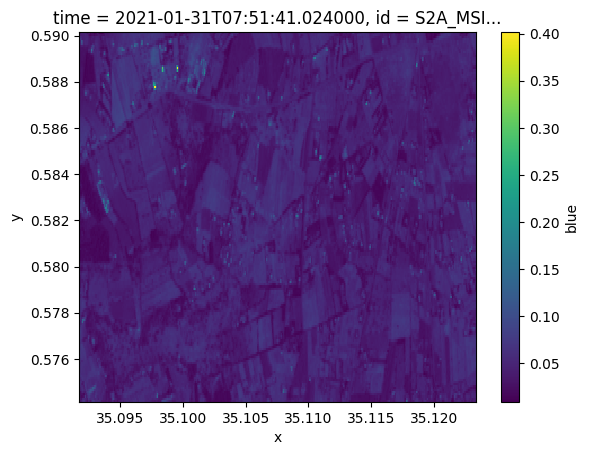

In [ ]:
s2_xarray_ds.isel(time=2).blue.plot(cmap='viridis')

## Time series

`Time series analysis—These methods investigate data sequences as a function
of time. The time series is decomposed into a long-term trend, a systematic
(periodic, cyclic, rhythmic) component, and an irregular (random, stochastic)
component. A widely used technique for describing the cyclic components of a
time series is spectral analysis. Examples of the application of these techniques
include investigating cyclic climatic variations in sedimentary rocks and analyzing
seismic data.` source python recieps for Earth Sciences

In [ ]:
x, y = 35.091792388971584, 0.5900286891046989

In [ ]:
# lets calculate an index for example ndvi
ndvi = (s2_xarray_ds.nir - s2_xarray_ds.red) / (s2_xarray_ds.nir + s2_xarray_ds.red)


In [ ]:
"""Canopy chrophophyl content index (CCCI): Measures nitrogen deficiency in crops including maize"""

ccci = ((s2_xarray_ds.red_edge - s2_xarray_ds.red)/(s2_xarray_ds.red_edge + s2_xarray_ds.red)) *((s2_xarray_ds.nir + s2_xarray_ds.red)/2).rename('ccci')


In [ ]:
"""Leaf Area Index (LAI)"""
"""
based on https://www.mdpi.com/2072-4292/12/9/1406
𝐋𝐀𝐈=0.310𝑺𝑹−0.098

(1)
where SR is the simple ratio of near-infrared (NIR) and red bands
(Band 8 and Band 4, respectively) calculated using Sentinel-2 Level-2A surface reflectance images.
"""
lai = (0.310 *ndvi - 0.098).rename('lai')

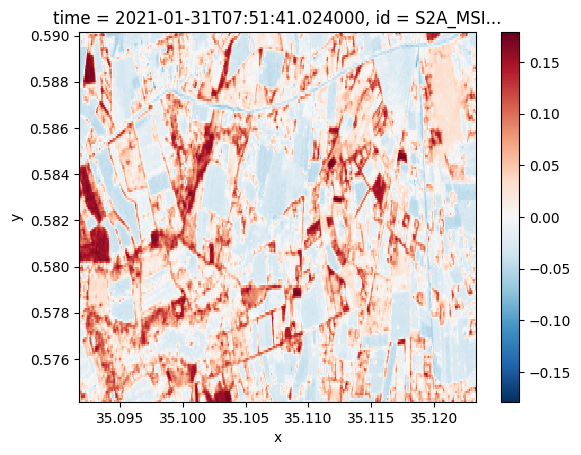

In [ ]:
lai.isel(time=2).plot()

In [ ]:
""" NDWI"""
ndwi = ((s2_xarray_ds.green-s2_xarray_ds.nir)/(s2_xarray_ds.green+s2_xarray_ds.nir)).rename('ndwi')

In [ ]:
time_series_ndvi = ndvi.rename('NDVI').interp(x=x, y=y).compute()

In [ ]:
time_series_ndvi

<xarray.DataArray 'NDVI' (time: 14)> Size: 112B
array([0.31339168, 0.29028095, 0.27754323, 0.26066687, 0.40133802,
       0.41236739, 0.39737376, 0.34206317, 0.35558939, 0.36838678,
       0.24411312, 0.53535334, 0.5068797 , 0.48889462])
Coordinates: (12/37)
  * time                                     (time) datetime64[ns] 112B 2021-...
    id                                       (time) <U54 3kB 'S2B_MSIL2A_2021...
    s2:medium_proba_clouds_percentage        (time) float64 112B 0.446 ... 0....
    s2:generation_time                       (time) <U27 2kB '2021-01-07T01:4...
    s2:mean_solar_zenith                     (time) float64 112B 32.48 ... 31.19
    platform                                 (time) <U11 616B 'Sentinel-2B' ....
    ...                                       ...
    sat:orbit_state                          <U10 40B 'descending'
    s2:granule_id                            (time) <U62 3kB 'S2B_OPER_MSI_L2...
    s2:mean_solar_azimuth                    (time) float64 112B 136.2 ... 41.93
    epsg                                     int64 8B 4326
    x                                        float64 8B 35.28
    y                                        float64 8B 0.6089

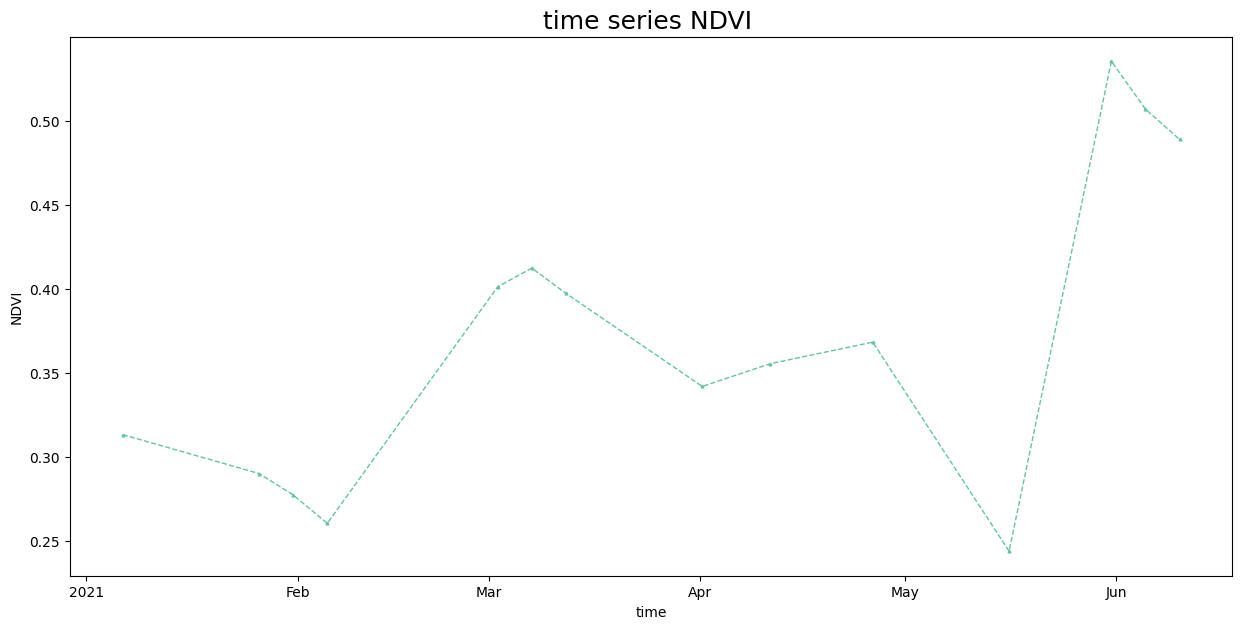

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
time_series_ndvi.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)


ax.set_title('time series NDVI ', size = 18)

plt.show()

# Data aggregation
Data aggregation can be useful if you want to reduce the number of observation and also part of handle noise we can use `xarray's` resample to do that you may refer to [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) for time series frequencis

In [ ]:
monthly_ndvi_data = ndvi.resample(time='MS', label='left').mean()

In [ ]:
monthly_ndvi_data

<xarray.DataArray (time: 6, y: 155, x: 220)> Size: 2MB
dask.array<stack, shape=(6, 155, 220), dtype=float64, chunksize=(1, 155, 220), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * x                                        (x) float64 2kB 35.28 ... 35.3
  * y                                        (y) float64 1kB 0.6089 ... 0.595
    s2:mgrs_tile                             <U5 20B '36NYF'
    proj:code                                <U10 40B 'EPSG:32636'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:degraded_msi_data_percentage          float64 8B 0.0
    ...                                       ...
    constellation                            <U10 40B 'Sentinel 2'
    sat:relative_orbit                       int64 8B 135
    s2:product_type                          <U7 28B 'S2MSI2A'
    sat:orbit_state                          <U10 40B 'descending'
    epsg                                     int64 8B 4326
  * time                                     (time) datetime64[ns] 48B 2021-0...

In [ ]:
time_series_monthly_ndvi = monthly_ndvi_data.interp(x=x, y=y).compute()

In [ ]:
time_series_monthly_ndvi

<xarray.DataArray (time: 6)> Size: 48B
array([0.29373862, 0.26066687, 0.40369306, 0.35534645, 0.38973323,
       0.49788716])
Coordinates: (12/14)
    s2:mgrs_tile                             <U5 20B '36NYF'
    proj:code                                <U10 40B 'EPSG:32636'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:degraded_msi_data_percentage          float64 8B 0.0
    instruments                              <U3 12B 'msi'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    ...                                       ...
    s2:product_type                          <U7 28B 'S2MSI2A'
    sat:orbit_state                          <U10 40B 'descending'
    epsg                                     int64 8B 4326
  * time                                     (time) datetime64[ns] 48B 2021-0...
    x                                        float64 8B 35.28
    y                                        float64 8B 0.6089

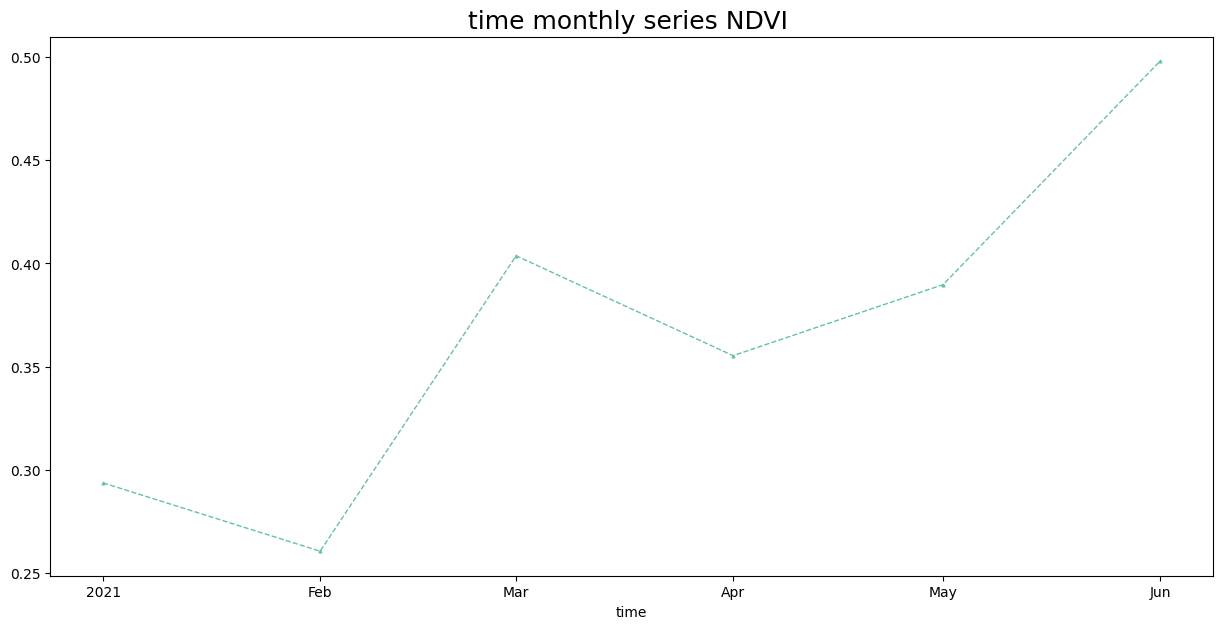

In [ ]:
# plot the monthly dataset
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
time_series_monthly_ndvi.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)
ax.set_title('time monthly series NDVI ', size = 18)

plt.show()

Export data for training an ML model

In [ ]:
# convert the xarray.Dataset to dask dataframe
s2_dask_df = s2_xarray_ds.to_dask_dataframe()
# you may as well consider to export as images or netcdf files

In [ ]:
s2_dask_df.head()

,time,y,x,id,s2:medium_proba_clouds_percentage,s2:generation_time,s2:mean_solar_zenith,platform,s2:mgrs_tile,s2:thin_cirrus_percentage,...,sat:orbit_state,s2:granule_id,s2:mean_solar_azimuth,epsg,blue,green,red,nir,swir16,swir22
0,2021-01-06 07:52:19.024,0.608893,35.284491,S2B_MSIL2A_20210106T075219_R135_T36NYF_2021010...,0.44601,2021-01-07T01:49:37.604Z,32.48178,Sentinel-2B,36NYF,0.024924,...,descending,S2B_OPER_MSI_L2A_TL_ESRI_20210107T014939_A0200...,136.24777,4326,0.0521,0.0742,0.1058,0.2034,0.3404,0.2360
1,2021-01-06 07:52:19.024,0.608893,35.284581,S2B_MSIL2A_20210106T075219_R135_T36NYF_2021010...,0.44601,2021-01-07T01:49:37.604Z,32.48178,Sentinel-2B,36NYF,0.024924,...,descending,S2B_OPER_MSI_L2A_TL_ESRI_20210107T014939_A0200...,136.24777,4326,0.0550,0.0789,0.1122,0.2126,0.3404,0.2360
2,2021-01-06 07:52:19.024,0.608893,35.284671,S2B_MSIL2A_20210106T075219_R135_T36NYF_2021010...,0.44601,2021-01-07T01:49:37.604Z,32.48178,Sentinel-2B,36NYF,0.024924,...,descending,S2B_OPER_MSI_L2A_TL_ESRI_20210107T014939_A0200...,136.24777,4326,0.0568,0.0818,0.1166,0.2216,0.3482,0.2414
3,2021-01-06 07:52:19.024,0.608893,35.284761,S2B_MSIL2A_20210106T075219_R135_T36NYF_2021010...,0.44601,2021-01-07T01:49:37.604Z,32.48178,Sentinel-2B,36NYF,0.024924,...,descending,S2B_OPER_MSI_L2A_TL_ESRI_20210107T014939_A0200...,136.24777,4326,0.0542,0.0781,0.1070,0.2202,0.3482,0.2414
4,2021-01-06 07:52:19.024,0.608893,35.284851,S2B_MSIL2A_20210106T075219_R135_T36NYF_2021010...,0.44601,2021-01-07T01:49:37.604Z,32.48178,Sentinel-2B,36NYF,0.024924,...,descending,S2B_OPER_MSI_L2A_TL_ESRI_20210107T014939_A0200...,136.24777,4326,0.0551,0.0783,0.1102,0.2202,0.3428,0.2420


In [ ]:
# expor to your desired format
s2_dask_df.to_csv('s2_dask_df.csv') #or parquet


## Further exploration

* Univeriate and multi variant data processing and their application in Earth Science problems
* Signal processing for Earth sciences
* Analysis of Direction Data
* Zonal statistics
* combining data from different data sources

# Self Challenges
* Learn about active sensors (senstinel one)
* Use stack api to acquire, pre-process to xarray.Dataset
* Combine Sentinel one with sentinel 2 data, handle the dates to have one dataset ready for ML purposes.

# Learning Resources

* The internet (!!)
* EarthObservation college: `https://eo-college.org/`

